In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.proportion import proportion_confint

In [3]:
excel_file = "/content/GRAN_TABLA(SIN ID).xlsx"
df = pd.read_excel(excel_file)

print("Columna:")
print(df.dtypes)

Columna:
NME_CONVOCATORIA            object
ANO_CONVO                   object
NME_ESP_AREA_PR             object
NME_AREA_PR                 object
NME_GRAN_AREA_PR            object
NME_GENERO_PR               object
NME_PAIS_NAC_PR             object
NME_REGION_NAC_PR           object
NME_DEPARTAMENTO_NAC_PR     object
NME_MUNICIPIO_NAC_PR        object
NME_NIV_FORM_PR             object
NRO_ORDEN_FORM_PR            int64
NME_CLASIFICACION_PR        object
ORDEN_CLAS_PR                int64
EDAD_ANOS_PR               float64
NME_PAIS_RES_PR             object
NME_REGION_RES_PR           object
NME_DEPARTAMENTO_RES_PR     object
NME_MUNICIPIO_RES_PR        object
ID_VICTIMA_CONFLICTO        object
TXT_GRUPO_ETNICO            object
TXT_POBLACION_DISCA         object
INST_FILIA                  object
dtype: object


In [4]:
print("dimensiones de la base:")
print(df.shape)

dimensiones de la base:
(50891, 23)


In [5]:
df['ANO_CONVO'] = pd.to_datetime(df['ANO_CONVO'], errors='coerce')

In [6]:
print("\nLos valores únicos en la columna 'NME_CONVOCATORIA' son:")
print(df['NME_CONVOCATORIA'].unique())


Los valores únicos en la columna 'NME_CONVOCATORIA' son:
['Convocatoria 781 de 2017' 'Convocatoria 833 de 2018'
 'Convocatoria 894 de 2021']


In [7]:
#valores faltantes por columna
missing_values = df.isnull().sum()
columns_with_na = missing_values[missing_values > 0]

print("Columnas con valores faltantes:")
print(columns_with_na)

Columnas con valores faltantes:
ANO_CONVO       21094
EDAD_ANOS_PR        1
INST_FILIA       4273
dtype: int64


Analisis Gran Tabla

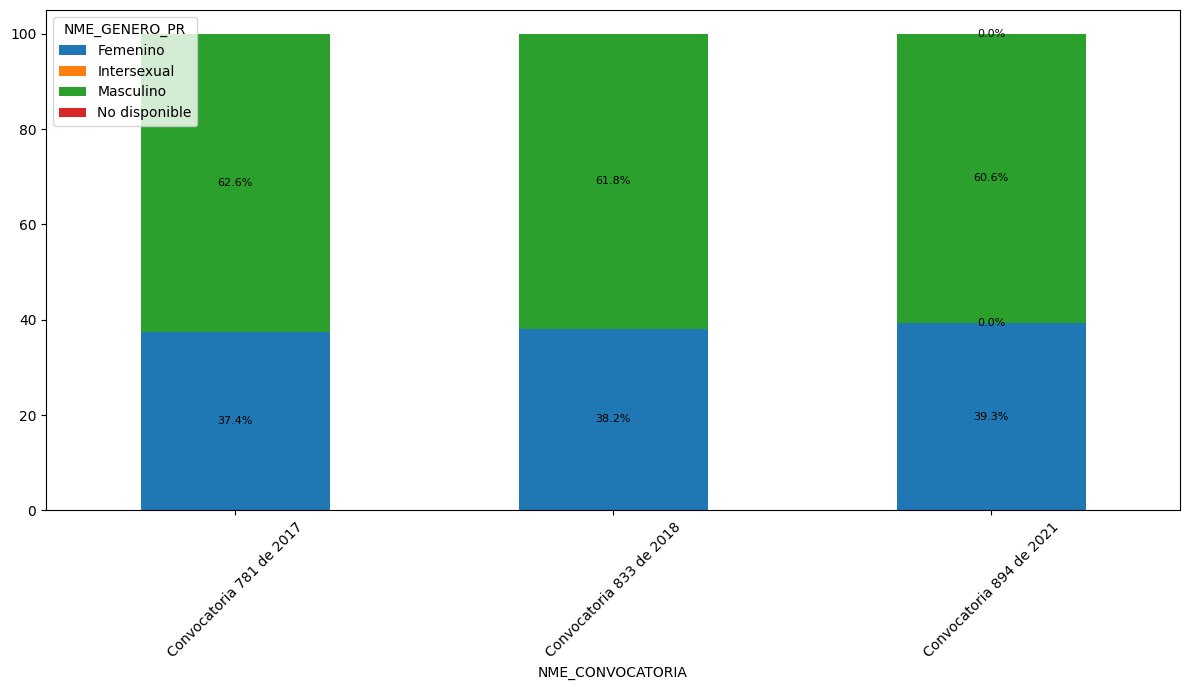

In [8]:
x = 'NME_CONVOCATORIA'
hue = 'NME_GENERO_PR'

# tabla de conteos
tbl = df.groupby([x, hue]).size().unstack(fill_value=0)
# porcentajes por (convocatoria)
tbl_pct = tbl.div(tbl.sum(axis=1), axis=0) * 100
# plot stacked bars con porcentajes
ax = tbl_pct.plot(kind='bar', stacked=True, figsize=(12,7), rot=45)

# etiquetas de porcentaje
for i, (idx, row) in enumerate(tbl_pct.iterrows()):
    cum = 0
    for j, val in enumerate(row):
        if val > 0:
            ax.text(i, cum + val/2, f'{val:.1f}%', ha='center', va='center', fontsize=8)
            cum += val
plt.tight_layout()

Las proporciones de mujeres investigadoras en las tres convocatorias están todas en torno al 37–39%, con diferencias pequeñas.
Los datos sugieren una tendencia de incremento en la proporción a lo largo del tiempo.

In [10]:
# tabla de contingencia (conteos)
contingency_table = pd.crosstab(df['NME_CLASIFICACION_PR'], df['NME_REGION_RES_PR'])

# orden de clasificación
classification_order = df[['NME_CLASIFICACION_PR', 'ORDEN_CLAS_PR']].drop_duplicates()
classification_order = classification_order.set_index('NME_CLASIFICACION_PR')

# Añadir orden y ordenar la tabla
contingency_table_ordered = contingency_table.join(classification_order)
contingency_table_ordered = contingency_table_ordered.sort_values(by='ORDEN_CLAS_PR')

# copia de los conteos
contingency_counts = contingency_table_ordered.drop(columns='ORDEN_CLAS_PR')

# porcentajes por fila
contingency_percent = contingency_counts.div(contingency_counts.sum(axis=1), axis=0) * 100

# conteos y porcentajes
contingency_final = contingency_counts.astype(str) + " (" + contingency_percent.round(1).astype(str) + "%)"

# tabla final ordenada
display(contingency_final)

,Caribe,Centro Oriente,Centro Sur,Distrito Capital,Eje Cafetero,Exterior,Llano,No disponible,Pacífico
NME_CLASIFICACION_PR,,,,,,,,,
Investigador Junior,4269 (13.8%),3754 (12.2%),969 (3.1%),9784 (31.7%),6998 (22.7%),948 (3.1%),328 (1.1%),242 (0.8%),3574 (11.6%)
Investigador Asociado,2266 (18.1%),1708 (13.6%),297 (2.4%),4001 (31.9%),2726 (21.7%),121 (1.0%),92 (0.7%),29 (0.2%),1305 (10.4%)
Investigador Sénior,1067 (14.8%),687 (9.5%),111 (1.5%),2426 (33.6%),2020 (28.0%),175 (2.4%),20 (0.3%),13 (0.2%),701 (9.7%)
Investigador Emérito,24 (9.2%),15 (5.8%),3 (1.2%),106 (40.8%),59 (22.7%),1 (0.4%),1 (0.4%),1 (0.4%),50 (19.2%)


Para todos los niveles de clasificación, Distrito Capital y Eje Cafetero concentran la mayor parte de los investigadores.
Aproximadamente el 50% al 60% de cada nivel de clasificación reside en estas dos regiones.

Los Eméritos, aunque son pocos, también presentan una presencia relevante en el Pacífico (19.2%) respecto a los demás grupos.

In [14]:
# chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)
# Total de observaciones
n = contingency_table.sum().sum()
# Número de filas y columnas
r, k = contingency_table.shape
# Cramér's V
cramers_v = np.sqrt((chi2 / n) / (min(k - 1, r - 1)))

print(f"Cramér's V: {cramers_v:.4f}")

Cramér's V: 0.0664


Existe una relación entre la clasificación del investigador y su región de residencia, pero esta relación es débil. La región donde reside un investigador no es un factor fuertemente asociado con su nivel de clasificación (Junior, Asociado, Sénior, Emérito).

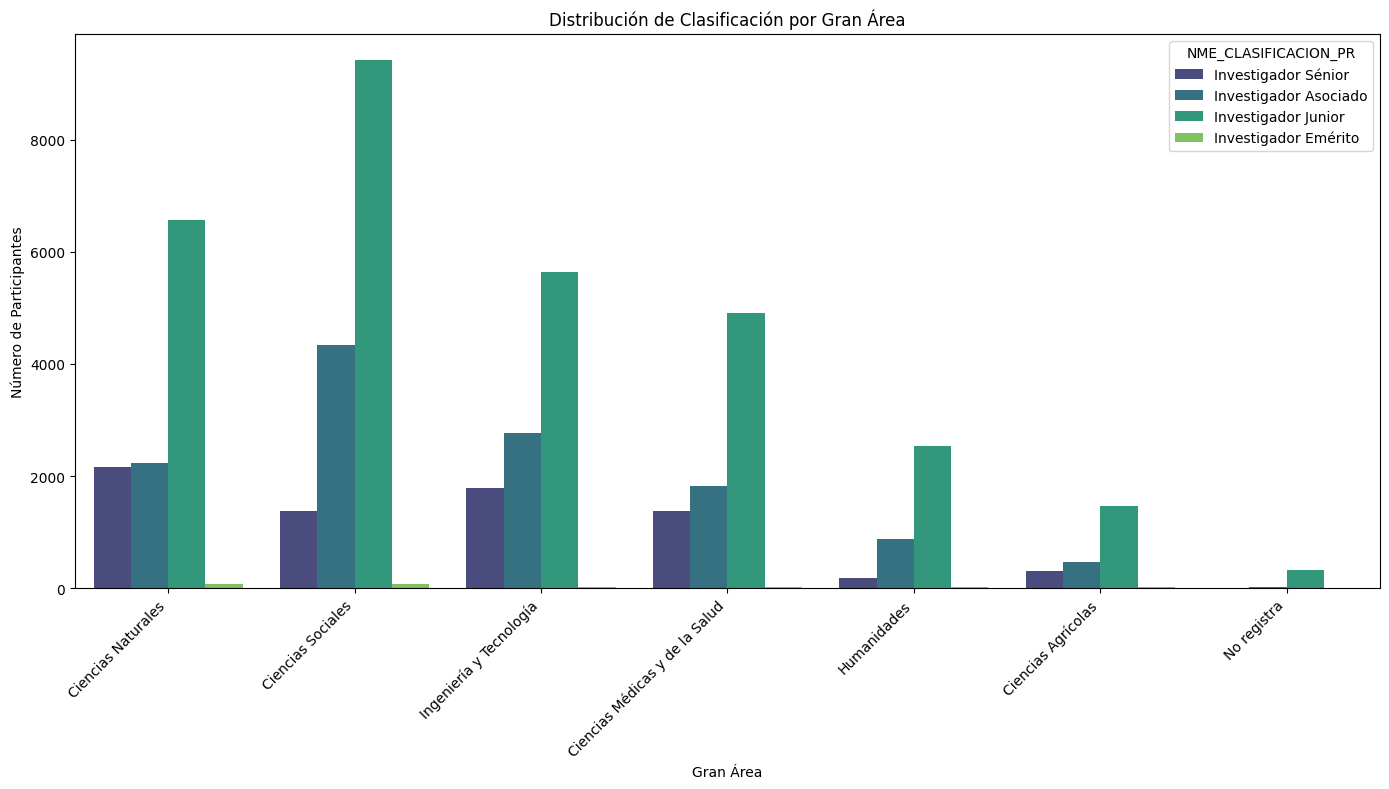

In [ ]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='NME_GRAN_AREA_PR', hue='NME_CLASIFICACION_PR', palette='viridis')

plt.title('Distribución de Clasificación por Gran Área')
plt.xlabel('Gran Área')
plt.ylabel('Número de Participantes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
# conteos
contingency_table = pd.crosstab(df['NME_GRAN_AREA_PR'], df['NME_CLASIFICACION_PR'])

# porcentajes por fila (dentro de cada gran área)
contingency_percent = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Tabla final
contingency_final = contingency_table.astype(str) + " (" + contingency_percent.round(1).astype(str) + "%)"
display(contingency_final)


NME_CLASIFICACION_PR,Investigador Asociado,Investigador Emérito,Investigador Junior,Investigador Sénior
NME_GRAN_AREA_PR,,,,
Ciencias Agrícolas,464 (20.5%),17 (0.8%),1471 (65.0%),310 (13.7%)
Ciencias Médicas y de la Salud,1823 (22.4%),34 (0.4%),4901 (60.2%),1380 (17.0%)
Ciencias Naturales,2237 (20.2%),78 (0.7%),6569 (59.4%),2170 (19.6%)
Ciencias Sociales,4333 (28.5%),80 (0.5%),9413 (61.9%),1383 (9.1%)
Humanidades,886 (24.4%),24 (0.7%),2545 (70.0%),181 (5.0%)
Ingeniería y Tecnología,2771 (27.1%),26 (0.3%),5647 (55.2%),1782 (17.4%)
No registra,31 (8.5%),1 (0.3%),320 (87.4%),14 (3.8%)


En la mayoría de los casos el nivel de Investigador Junior representa entre el 55% y el 70% de los investigadores dentro de su respectiva Gran Área. El sistema se compone principalmente de talento en las etapas iniciales.

Las áreas de Ingeniería y Tecnología y Ciencias Naturales muestran el perfil más consolidado. Ciencias Naturales, tiene la mayor proporción de Investigador Sénior (19.6%).

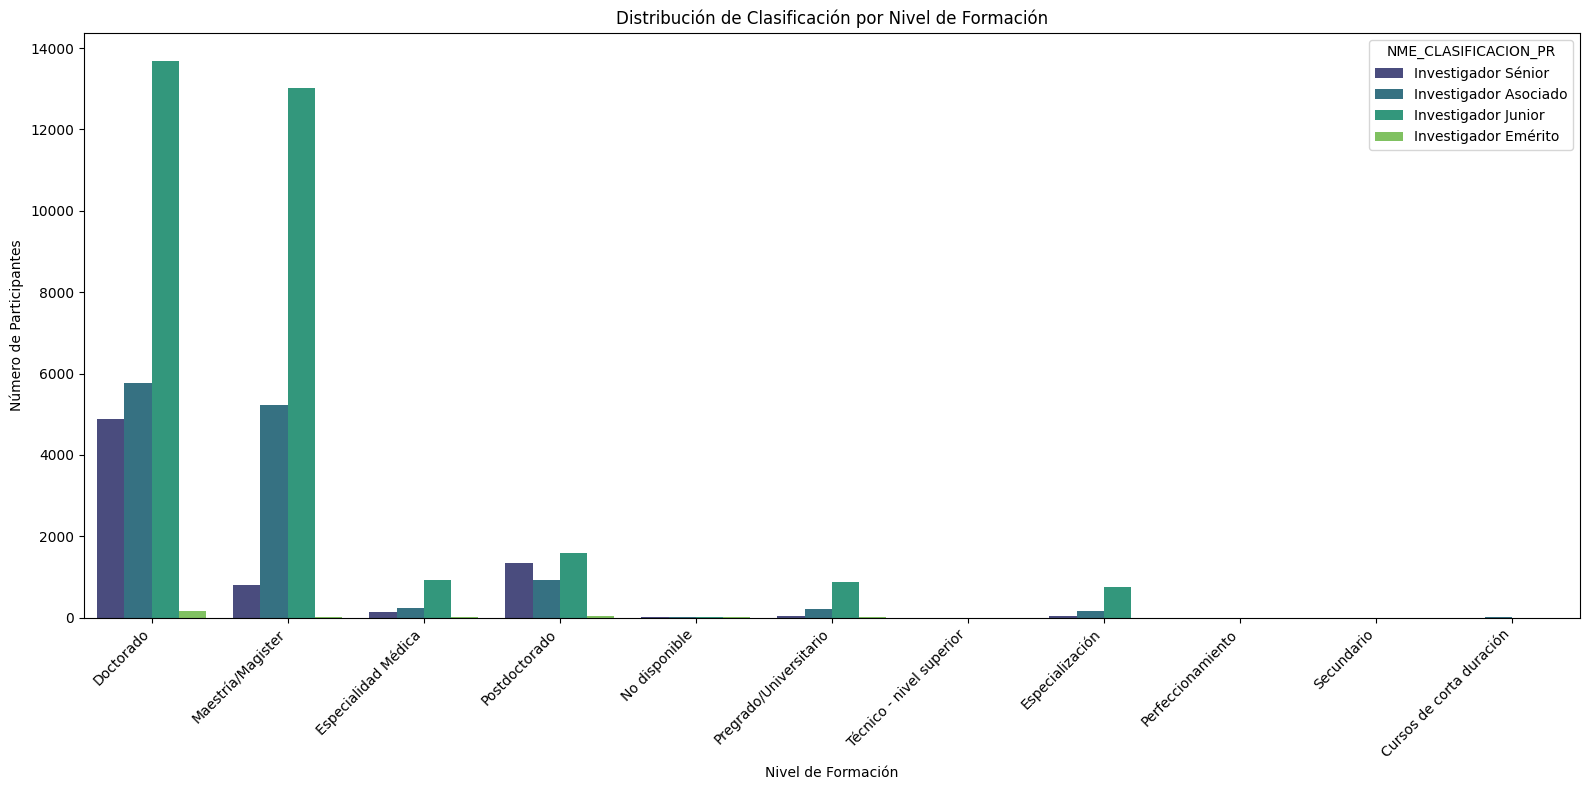

In [16]:
plt.figure(figsize=(16, 8))
sns.countplot(data=df, x='NME_NIV_FORM_PR', hue='NME_CLASIFICACION_PR', palette='viridis')

plt.title('Distribución de Clasificación por Nivel de Formación')
plt.xlabel('Nivel de Formación')
plt.ylabel('Número de Participantes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Niveles Inferiores (Técnico, Secundario, Cursos): Muestran una clasificación de 100% Investigador Junior.

Niveles Intermedios (Especialización, Pregrado): El perfil es predominantemente Junior (alrededor del 77% al 80%), con una baja proporción de Asociado (17% a 18%) y casi nula en Sénior (3% a 3.4%).

Niveles Superiores (Maestría, Doctorado, Postdoctorado): El porcentaje de Junior disminuye drásticamente y las clasificaciones superiores aumentan, mostrando una correlación entre el máximo grado de estudio y el nivel de clasificación.

In [17]:
contingency_table = pd.crosstab(df['NME_NIV_FORM_PR'], df['NME_CLASIFICACION_PR'])
# percentages
contingency_table_percentages_row = pd.crosstab(df['NME_NIV_FORM_PR'], df['NME_CLASIFICACION_PR'], normalize='index') * 100

print("\nTabla de Contingencia con Porcentajes:")
display(contingency_table_percentages_row.round(2)) # Round to 2 decimal places


Tabla de Contingencia con Porcentajes (por fila):


NME_CLASIFICACION_PR,Investigador Asociado,Investigador Emérito,Investigador Junior,Investigador Sénior
NME_NIV_FORM_PR,,,,
Cursos de corta duración,100.00,0.00,0.00,0.00
Doctorado,23.56,0.68,55.85,19.90
Especialidad Médica,17.50,0.39,72.01,10.11
Especialización,16.86,0.21,79.50,3.43
Maestría/Magister,27.44,0.13,68.26,4.17
No disponible,39.39,9.09,27.27,24.24
Perfeccionamiento,100.00,0.00,0.00,0.00
Postdoctorado,23.59,1.31,40.64,34.47
Pregrado/Universitario,18.78,0.71,77.51,3.00


Especialidad Médica: El perfil es muy sesgado hacia Investigador Junior (72.01%).

Maestría/Magister: Muestra una transición a Asociado (27.44%), pero una baja tasa de Sénior (4.17%).

El análisis muestra una relación clara entre el nivel de formación y la clasificación del investigador. Los niveles más bajos (pregrado, especialización) concentran mayoritariamente investigadores Junior, mientras que el doctorado y especialmente el postdoctorado se asocian con una mayor presencia en las categorías superiores (Sénior).
Esto sugiere que la Maestría es un buen punto de partida para la consolidación inicial, pero el Doctorado es casi indispensable para ascender al nivel Sénior.

Cramér's V (descriptivo, sin prueba inferencial): 0.0602


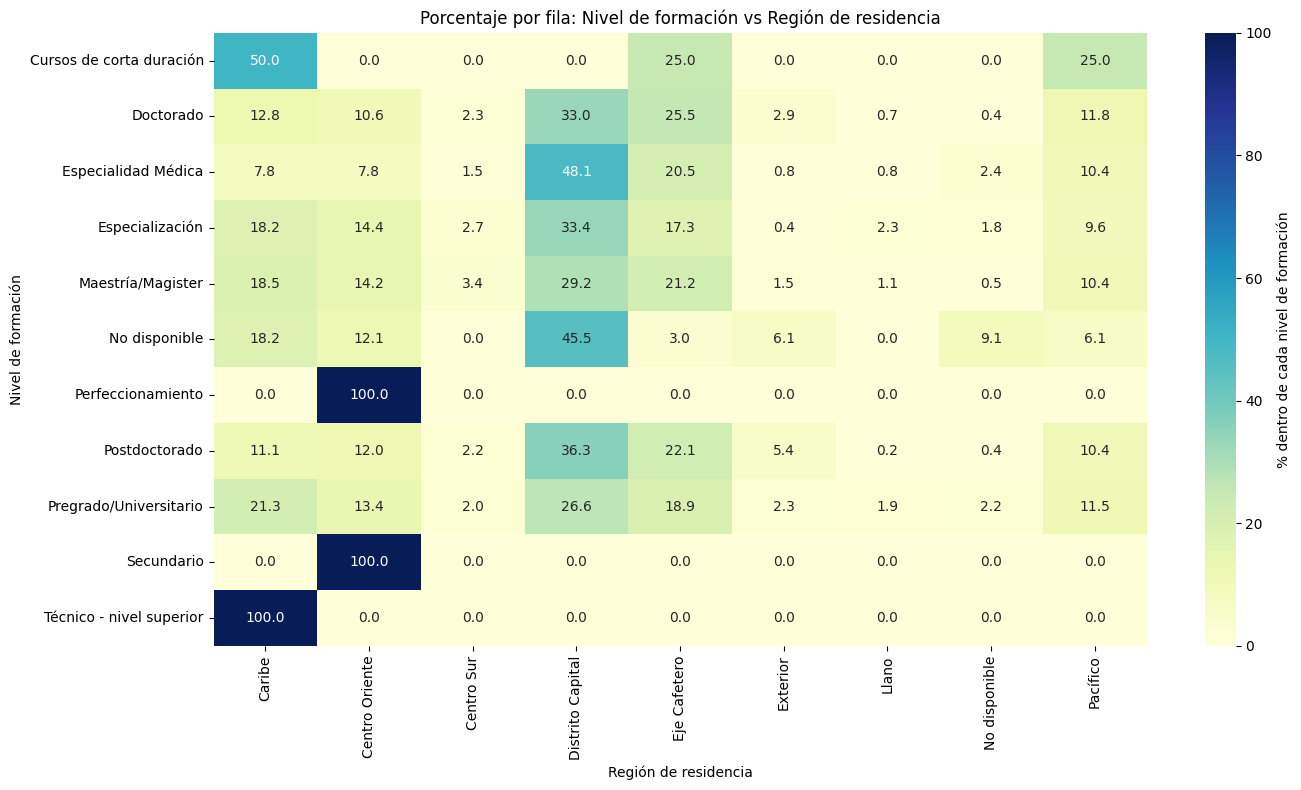

In [20]:
# 1) Construir la tabla de contingencia (conteos)
contingency_table_form_region = pd.crosstab(df['NME_NIV_FORM_PR'], df['NME_REGION_RES_PR'])

# 2) Calcular chi2 únicamente para obtener la estadística necesaria para Cramér's V
#    NO se usará el p-valor ni se interpretará el χ² inferencialmente.
chi2, p_unused, dof, expected = chi2_contingency(contingency_table_form_region, correction=False)

# 3) Calcular Cramér's V (manejo seguro si sólo hay 1 fila o 1 columna)
r, k = contingency_table_form_region.shape
n = contingency_table_form_region.sum().sum()

if min(k - 1, r - 1) <= 0 or n == 0:
    cramers_v = np.nan
    print("Imposible calcular Cramér's V: la tabla tiene 1 fila/columna o no hay observaciones.")
else:
    cramers_v = np.sqrt((chi2 / n) / (min(k - 1, r - 1)))

print(f"Cramér's V (descriptivo, sin prueba inferencial): {cramers_v:.4f}")

# 4) Heatmap de porcentajes por fila (más interpretable)
pct_by_row = contingency_table_form_region.div(contingency_table_form_region.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
sns.heatmap(pct_by_row, annot=True, fmt='.1f', cmap='YlGnBu',
            cbar_kws={'label': '% dentro de cada nivel de formación'})
plt.title("Porcentaje por fila: Nivel de formación vs Región de residencia")
plt.xlabel("Región de residencia")
plt.ylabel("Nivel de formación")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Los investigadores con Doctorado y Postdoctorado se concentran masivamente en Distrito Capital y Eje Cafetero. El resto de los niveles de formación presentan una distribución más dispersa, reflejando una mayor accesibilidad o una distribución más generalizada.

Pregrado/Universitario: Esta distribución es la más balanceada, reflejando mejor la distribución general de la población o el acceso a universidades básicas en casi todas las regiones.

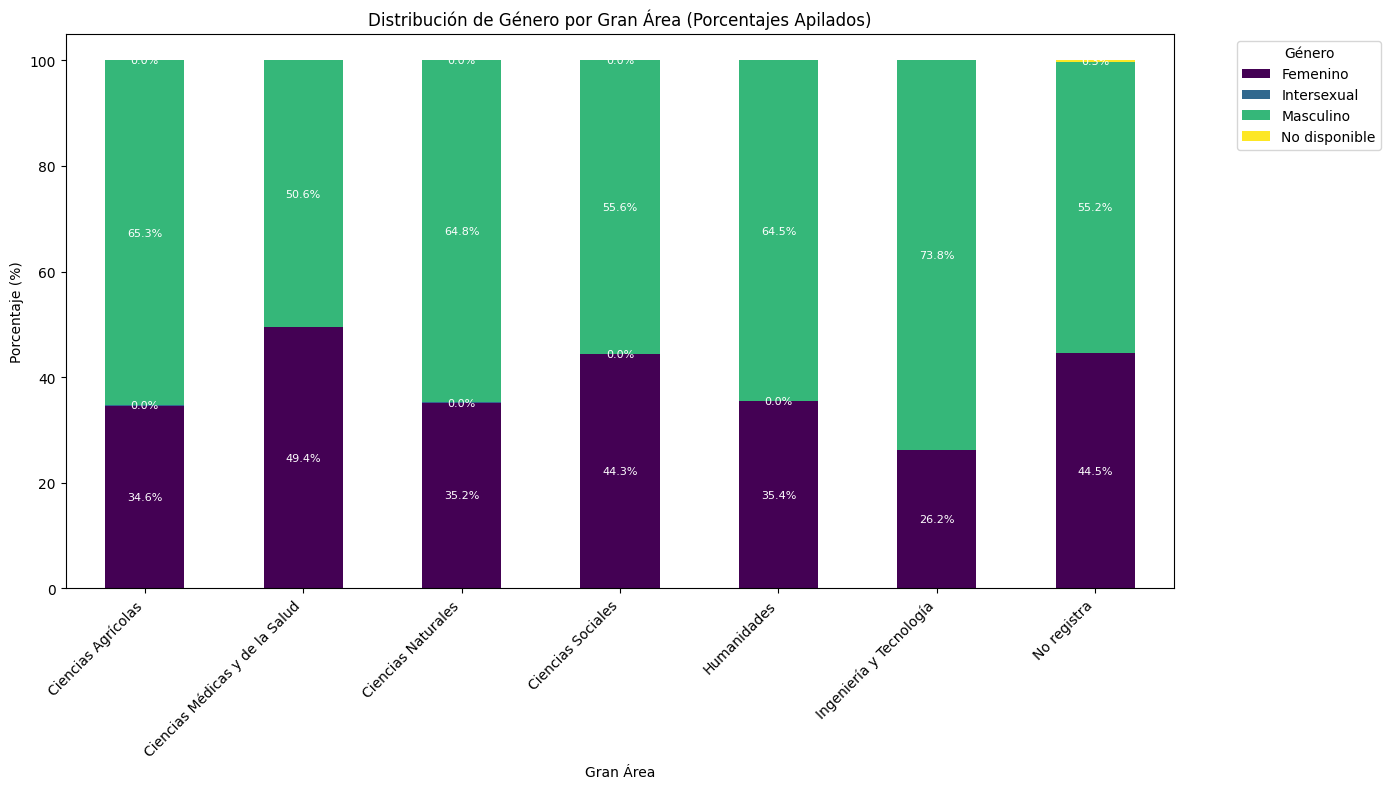

In [19]:
# Calcular conteos
counts = df.groupby(['NME_GRAN_AREA_PR', 'NME_GENERO_PR']).size().reset_index(name='Count')

# Totales por Gran Área
totals = counts.groupby('NME_GRAN_AREA_PR')['Count'].sum().reset_index(name='Total')

# porcentajes
counts = pd.merge(counts, totals, on='NME_GRAN_AREA_PR')
counts['Percentage'] = (counts['Count'] / counts['Total']) * 100
# Pivot para porcentajes
pivot_pct = counts.pivot(index='NME_GRAN_AREA_PR',
                         columns='NME_GENERO_PR',
                         values='Percentage').fillna(0)

# barras apiladas con porcentajes
ax = pivot_pct.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')

plt.title('Distribución de Género por Gran Área (Porcentajes Apilados)')
plt.xlabel('Gran Área')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title="Género", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# etiquetas dentro de las barras
for xpos, (area, row) in enumerate(pivot_pct.iterrows()):  # usar posición numérica
    cum = 0
    for val in row:
        if val > 0:
            ax.text(xpos, cum + val/2, f'{val:.1f}%', ha='center', va='center', fontsize=8, color='white')
            cum += val

plt.show()

Las mujeres tienden a concentrarse en las Ciencias Sociales y Ciencias de la Salud, mientras que los hombres dominan las Ingenierías y Ciencias Naturales.

Ingeniería y Tecnología (M: 73.8% / F: 26.2%): Esta área es la más masculinizada, con una proporción de investigadores hombres más del doble que la de mujeres.

Ciencias Médicas y de la Salud (M: 50.6% / F: 49.4%): Muestra un alto grado de paridad, siendo el área más equitativa, con una diferencia de solo 5 puntos porcentuales.

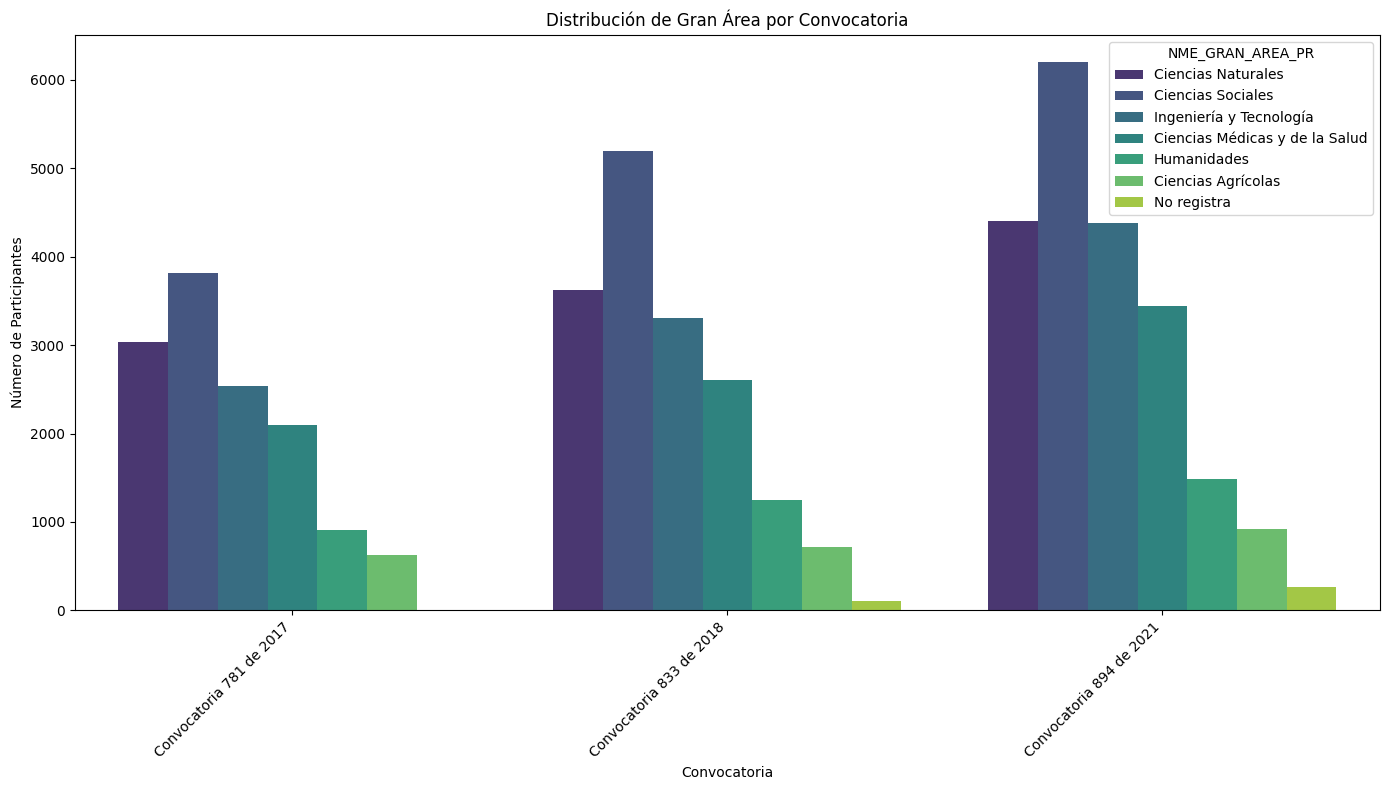

In [ ]:
plt.figure(figsize=(14, 8)) # Adjust figure size as needed
sns.countplot(data=df, x='NME_CONVOCATORIA', hue='NME_GRAN_AREA_PR', palette='viridis')

plt.title('Distribución de Gran Área por Convocatoria')
plt.xlabel('Convocatoria')
plt.ylabel('Número de Participantes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Create a contingency table
contingency_table_conv_area = pd.crosstab(df['NME_CONVOCATORIA'], df['NME_GRAN_AREA_PR'])

# Perform the chi-squared test
chi2_conv_area, p_conv_area, dof_conv_area, expected_conv_area = chi2_contingency(contingency_table_conv_area)

print("Resultados de la Prueba Chi-cuadrado para NME_CONVOCATORIA vs NME_GRAN_AREA_PR:")
print(f"Estadístico Chi-cuadrado: {chi2_conv_area:.4f}")
print(f"Valor p: {p_conv_area:.4f}")
print(f"Grados de libertad: {dof_conv_area}")

# Optionally, calculate Pearson's contingency coefficient as a measure of association strength
n_conv_area = contingency_table_conv_area.sum().sum()
contingency_coefficient_conv_area = np.sqrt(chi2_conv_area / (chi2_conv_area + n_conv_area))
print(f"Coeficiente de Contingencia de Pearson: {contingency_coefficient_conv_area:.4f}")

Resultados de la Prueba Chi-cuadrado para NME_CONVOCATORIA vs NME_GRAN_AREA_PR:
Estadístico Chi-cuadrado: 226.3339
Valor p: 0.0000
Grados de libertad: 12
Coeficiente de Contingencia de Pearson: 0.0665


In [ ]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
# porcentaje de celdas con expected < 5
pct_small = (expected < 5).sum() / expected.size
print(f"Porcentaje de celdas con expected < 5: {pct_small*100:.1f}%")
if pct_small > 0.2:
    print("Advertencia: >20% celdas con frecuencia esperada < 5. Considerar Fisher (2x2), test exacto Monte Carlo o agrupar categorías.")


Porcentaje de celdas con expected < 5: 43.2%
Advertencia: >20% celdas con frecuencia esperada < 5. Considerar Fisher (2x2), test exacto Monte Carlo o agrupar categorías.


In [ ]:
# Drop rows with missing values in the relevant columns for the test
df_cleaned = df.dropna(subset=['NME_GRAN_AREA_PR', 'EDAD_ANOS_PR']).copy()

# Group the numerical data by the categories of the categorical variable
# Ensure there's more than one group with data for the test
groups_area = [group['EDAD_ANOS_PR'].values for name, group in df_cleaned.groupby('NME_GRAN_AREA_PR') if len(group) > 0]

# Perform the Kruskal-Wallis test only if there are at least two groups with data
if len(groups_area) >= 2:
    statistic_area, p_value_area = kruskal(*groups_area)

    print("Resultados de la Prueba de Kruskal-Wallis para NME_GRAN_AREA_PR vs EDAD_ANOS_PR:")
    print(f"Estadístico Kruskal-Wallis: {statistic_area:.4f}")
    print(f"Valor p: {p_value_area:.4f}")

    # Interpret the result
    alpha = 0.05
    if p_value_area < alpha:
        print(f"El valor p ({p_value_area:.4f}) es menor que el nivel de significancia ({alpha}), por lo tanto, rechazamos la hipótesis nula.")
        print("Existe una diferencia estadísticamente significativa en la distribución de 'EDAD_ANOS_PR' entre las diferentes grandes áreas.")
    else:
        print(f"El valor p ({p_value_area:.4f}) es mayor que el nivel de significancia ({alpha}), por lo tanto, no rechazamos la hipótesis nula.")
        print("No existe una diferencia estadísticamente significativa en la distribución de 'EDAD_ANOS_PR' entre las diferentes grandes áreas.")
else:
    print("No hay suficientes grupos con datos para realizar la prueba de Kruskal-Wallis para NME_GRAN_AREA_PR vs EDAD_ANOS_PR.")

Resultados de la Prueba de Kruskal-Wallis para NME_GRAN_AREA_PR vs EDAD_ANOS_PR:
Estadístico Kruskal-Wallis: 1222.6708
Valor p: 0.0000
El valor p (0.0000) es menor que el nivel de significancia (0.05), por lo tanto, rechazamos la hipótesis nula.
Existe una diferencia estadísticamente significativa en la distribución de 'EDAD_ANOS_PR' entre las diferentes grandes áreas.


In [ ]:
# Install the scikit-posthocs library if you haven't already
!pip install scikit-posthocs
import scikit_posthocs as sp

# Drop rows with missing values in the relevant columns
df_cleaned = df.dropna(subset=['NME_GRAN_AREA_PR', 'EDAD_ANOS_PR']).copy()

# Perform Dunn's test with Bonferroni correction
# The input to sp.posthoc_dunn is a list of arrays, where each array contains the data for one group.
# We need to group the data by 'NME_GRAN_AREA_PR' and extract the 'EDAD_ANOS_PR' values for each group.
groups_data = df_cleaned.groupby('NME_GRAN_AREA_PR')['EDAD_ANOS_PR'].apply(list)

# sp.posthoc_dunn requires a list of arrays, so we need to extract the lists from the Series
group_arrays = groups_data.tolist()

# Get the group names for the index and columns of the results table
group_names = groups_data.index.tolist()

# Perform Dunn's test
dunn_results = sp.posthoc_dunn(group_arrays, p_adjust='bonferroni')

# Rename the index and columns with the group names
dunn_results.columns = group_names
dunn_results.index = group_names

print("Resultados de la prueba post-hoc de Dunn (con corrección de Bonferroni) para NME_GRAN_AREA_PR y EDAD_ANOS_PR:")
display(dunn_results)

Resultados de la prueba post-hoc de Dunn (con corrección de Bonferroni) para NME_GRAN_AREA_PR y EDAD_ANOS_PR:


,Ciencias Agrícolas,Ciencias Médicas y de la Salud,Ciencias Naturales,Ciencias Sociales,Humanidades,Ingeniería y Tecnología,No registra
Ciencias Agrícolas,1.000000e+00,1.000000e+00,1.593464e-08,1.000000e+00,8.336801e-01,3.809704e-53,7.035993e-19
Ciencias Médicas y de la Salud,1.000000e+00,1.000000e+00,1.272001e-30,1.000000e+00,1.000000e+00,2.630155e-151,2.147702e-23
Ciencias Naturales,1.593464e-08,1.272001e-30,1.000000e+00,3.033418e-34,1.350864e-23,4.372352e-56,2.753978e-11
Ciencias Sociales,1.000000e+00,1.000000e+00,3.033418e-34,1.000000e+00,5.155644e-01,2.225235e-187,1.716556e-22
Humanidades,8.336801e-01,1.000000e+00,1.350864e-23,5.155644e-01,1.000000e+00,9.989264e-102,2.713044e-24
Ingeniería y Tecnología,3.809704e-53,2.630155e-151,4.372352e-56,2.225235e-187,9.989264e-102,1.000000e+00,6.242165e-02
No registra,7.035993e-19,2.147702e-23,2.753978e-11,1.716556e-22,2.713044e-24,6.242165e-02,1.000000e+00


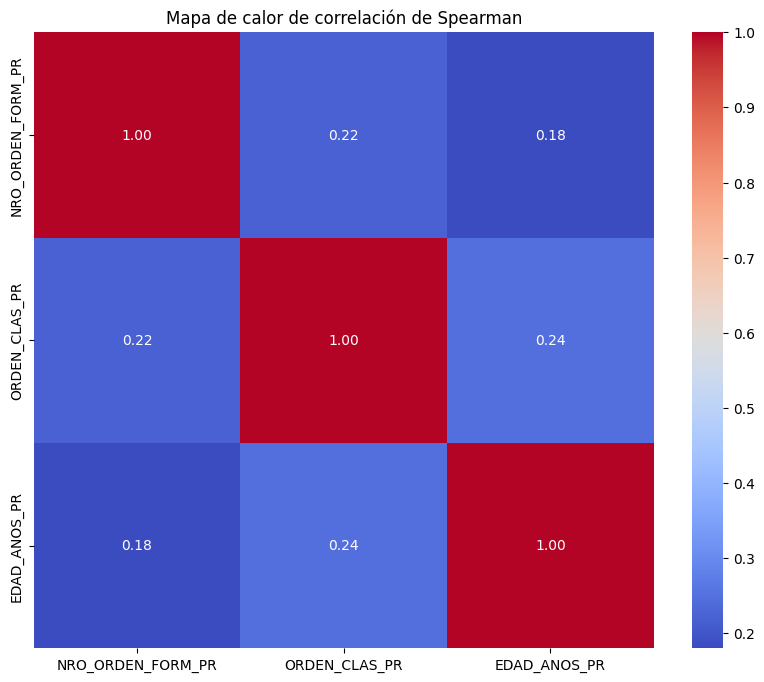

In [ ]:
# Seleccionar solo las columnas numéricas
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación utilizando el método de Spearman
correlation_matrix_spearman = df_numeric.corr(method='spearman')

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de calor de correlación de Spearman')
plt.show()